In [102]:
# IMPORT LIBRARIES AND CONFIG

import os
# import datetime
from numpy import savez_compressed
from numpy import load

import IPython
import IPython.display

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf

from datetime import datetime, date
import calendar


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# tf.debugging.set_log_device_placement(True)


In [103]:
# GLOBAL VARIABLES

INPUT_SYMBOL = 'EURUSD'

LABEL_BASE_RATE = 0.0008
LABEL_RANGE = 48

IMAGE_LENGTH_M15 = 48
IMAGE_LENGTH_H1 = 48
IMAGE_LENGTH_H4 = 24
IMAGE_LENGTH_M5 = 24
IMAGE_LENGTH_D1 = 7
IMAGE_WIDTH = IMAGE_LENGTH_M15 + IMAGE_LENGTH_H1 + IMAGE_LENGTH_H4 + IMAGE_LENGTH_M5 + IMAGE_LENGTH_D1

TRAIN_RATE = 0.9

DAY = 2 * np.pi / (24*60*60)
WEEK = DAY / 7
YEAR = DAY / (365.2425)


MAX_BAR = 250000
MAX_LENGTH_X = int((MAX_BAR - IMAGE_LENGTH_M5) / 288)




In [3]:
# FETCH DATA FROM METATRADER AND SAVE TO FILE

from datetime import datetime
import MetaTrader5 as mt5
import numpy as np
from numpy import savez_compressed

DAY_HISTORY = 860
INPUT_STARTDATE = datetime(2020, 10, 15, 19)
INPUT_SYMBOL = 'EURUSD'


#     M15    H1     H4     M5     D1
# ----50-----50-----20-----20-----10

mt5.initialize()

m5 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_M5, INPUT_STARTDATE, DAY_HISTORY * 288 + IMAGE_LENGTH_M5)
err_m5 = mt5.last_error()
h4 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_H4, INPUT_STARTDATE, DAY_HISTORY * 6 + IMAGE_LENGTH_H4)
err_h4 = mt5.last_error()
m15 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_M15, INPUT_STARTDATE, DAY_HISTORY * 96 + IMAGE_LENGTH_M15)
err_m15 = mt5.last_error()
h1 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_H1, INPUT_STARTDATE, DAY_HISTORY * 24 + IMAGE_LENGTH_H1)
err_h1 = mt5.last_error()
d1 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_D1, INPUT_STARTDATE, DAY_HISTORY + IMAGE_LENGTH_D1 + 5)
err_d1 = mt5.last_error()

mt5.shutdown()

if err_d1[0] == mt5.RES_S_OK and err_h1[0] == mt5.RES_S_OK and err_h4[0] == mt5.RES_S_OK and err_m5[0] == mt5.RES_S_OK and err_m15[0] == mt5.RES_S_OK:
    savez_compressed(INPUT_SYMBOL + '.npz', d1=d1, m5=m5, m15=m15, h1=h1, h4=h4)
    print('DONE')
else:
    print('ERROR', err)



DONE


In [ ]:

# Problem:
# Given historical data
# Return the classification within the next 48 candles, including the current one

# Will it drop more than 0.4% Yes no
# Will it drop more than 0.8% Yes no
# Will it drop more than 1.2% Yes no
# Will it drop more than 1.6% Yes no
# Will it drop more than 2.0% Yes no
# Will it drop more than 2.4% Yes no
# Will it drop more than 2.8% Yes no
# Will it increase more than 0.4% Yes no
# Will it increase more than 0.8% Yes no
# Will it increase more than 1.2% Yes no
# Will it increase more than 1.6% Yes no
# Will it increase more than 2.0% Yes no
# Will it increase more than 2.4% Yes no
# Will it increase more than 2.8% Yes no


# A x B image, 0 -> 1
# R000 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open price, including the current one, sorted by time desc, scaled based on max and min of that range
# R001 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R002 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Low price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R003 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R004 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R005 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R006 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
# R007 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R008 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
# R009 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Close, not including the current one, sorted by time desc, scaled based on max and min of that range
# R010 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R011 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R012 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Max(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
# R013 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Min(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
# R014 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R015 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R016 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R017 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R018 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R019 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Close)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R020 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Open + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R021 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R022 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R023 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R024 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R025 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R026 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Volume, not including the current one, sorted by time desc, scaled based on max and min of that range
# R027 -> R053                        -    Diff from R001 -> R027, sorted by time desc, scaled based on max and min of that range
# R054 -> R080                        -    Diff from R028 -> R054, sorted by time desc, scaled based on max and min of that range
# R081 -> R107                        -    Diff from R055 -> R081, sorted by time desc, scaled based on max and min of that range
# R108 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day sin, including the current one, sorted by time desc, scaled based on -1-1
# R109 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day cos, including the current one, sorted by time desc, scaled based on -1-1
# R110 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of year, including the current one, sorted by time desc, scaled based on 0-365
# R111 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month, including the current one, sorted by time desc, scaled based on 0-30
# R112 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month reversed, including the current one, sorted by time desc, scaled based on 0-30
# R113 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of week, including the current one, sorted by time desc, scaled based on 0-6
# R114 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week sin, including the current one, sorted by time desc, scaled based on -1-1
# R115 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week cos, including the current one, sorted by time desc, scaled based on -1-1
# R116 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Hour of day, including the current one, sorted by time desc, scaled based on 0-23
# R117 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Minute of hour, including the current one, sorted by time desc, scaled based on 0-59
# R118 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year sin, including the current one, sorted by time desc, scaled based on -1-1
# R119 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year cos, including the current one, sorted by time desc, scaled based on -1-1
# R120 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Diff(Time), including the current one, sorted by time desc, scaled based on max and min of that range
# R121 Time
# R122 Will it drop more than 0.4% Yes no
# R123 Will it drop more than 0.8% Yes no
# R124 Will it drop more than 1.2% Yes no
# R125 Will it drop more than 1.6% Yes no
# R126 Will it drop more than 2.0% Yes no
# R127 Will it drop more than 2.4% Yes no
# R128 Will it drop more than 2.8% Yes no
# R129 Will it increase more than 0.4% Yes no
# R130 Will it increase more than 0.8% Yes no
# R131 Will it increase more than 1.2% Yes no
# R132 Will it increase more than 1.6% Yes no
# R133 Will it increase more than 2.0% Yes no
# R134 Will it increase more than 2.4% Yes no
# R135 Will it increase more than 2.8% Yes no



#     M15    H1     H4     M5     D1
# ----50-----50-----20-----20-----10
# |
# 120
# |
# ---------------------------


In [104]:
# LOAD RAW DATA FROM FILE

DAY_HISTORY_TO_PROCESS = 200

RAW_DATA_SIZE_M5 = DAY_HISTORY_TO_PROCESS * 288 + IMAGE_LENGTH_M5
RAW_DATA_SIZE_H4 = DAY_HISTORY_TO_PROCESS * 6 + IMAGE_LENGTH_H4
RAW_DATA_SIZE_M15 = DAY_HISTORY_TO_PROCESS * 96 + IMAGE_LENGTH_M15
RAW_DATA_SIZE_H1 = DAY_HISTORY_TO_PROCESS * 24 + IMAGE_LENGTH_H1
RAW_DATA_SIZE_D1 = DAY_HISTORY_TO_PROCESS + IMAGE_LENGTH_D1 + 5

# load dict of arrays
dict_data = load(INPUT_SYMBOL + '.npz')
raw_data_m5 = dict_data['m5'][-RAW_DATA_SIZE_M5:]
raw_data_m15 = dict_data['m15'][-RAW_DATA_SIZE_M15:]
raw_data_h1 = dict_data['h1'][-RAW_DATA_SIZE_H1:]
raw_data_h4 = dict_data['h4'][-RAW_DATA_SIZE_H4:]
raw_data_d1 = dict_data['d1'][-RAW_DATA_SIZE_D1:]

# TEST DATA ORDER

print(raw_data_m15['time'][0])
print(raw_data_m15['time'][-1])



1578525300
1602759600


In [105]:

def self_diff(a: np.ndarray, shift=1):
    t = a - np.roll(a, -shift)
    return t


# R122 Will it drop more than 0.4% Yes no
# R123 Will it drop more than 0.8% Yes no
# R124 Will it drop more than 1.2% Yes no
# R125 Will it drop more than 1.6% Yes no
# R126 Will it drop more than 2.0% Yes no
# R127 Will it drop more than 2.4% Yes no
# R128 Will it drop more than 2.8% Yes no
# R129 Will it increase more than 0.4% Yes no
# R130 Will it increase more than 0.8% Yes no
# R131 Will it increase more than 1.2% Yes no
# R132 Will it increase more than 1.6% Yes no
# R133 Will it increase more than 2.0% Yes no
# R134 Will it increase more than 2.4% Yes no
# R135 Will it increase more than 2.8% Yes no
def make_labels(raw_data, shift=48):
    h = raw_data['high']
    l = raw_data['low']
    o = raw_data['open']

    r = np.empty(shape=(14, len(h)), dtype=float)

    hh = [h[i:i + shift] for i in range(len(h))]
    max_ss = np.array([max(x / o[i] - 1) for i, x in enumerate(hh)])

    ll = [l[i:i + shift] for i in range(len(l))]
    min_ss = np.array([min(x / o[i] - 1) for i, x in enumerate(ll)])

    r[0:7] = [min_ss < (-i * LABEL_BASE_RATE) for i in range(1, 8)]
    r[7:14] = [max_ss > (i * LABEL_BASE_RATE) for i in range(1, 8)]

    return np.fliplr(r)


def build_features_one_timeframe(raw_data, add_labels=False):
    # raw_data: old -> new
    d = np.flip(raw_data)
    # d: new -> old
    ts = [datetime.fromtimestamp(x) for x in d['time']]
    tt = [t.timetuple() for t in ts]
    a = np.zeros(shape=(122, len(d)), dtype=float)
# R000 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[0] = d['open']
# R001 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[1] = d['high']
# R002 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Low price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[2] = d['low']
# R003 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[3] = d['close']
# R004 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[4] = np.maximum(a[0], a[3])
# R005 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[5] = np.minimum(a[0], a[3])
# R006 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[6] = a[3] - a[0]
# R007 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[7] = a[1] - a[2]
# R008 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[8] = a[1] - a[0]
# R009 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Close, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[9] = a[1] - a[3]
# R010 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[10] = a[3] - a[2]
# R011 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[11] = a[0] - a[2]
# R012 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Max(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
    a[12] = a[1] - a[4]
# R013 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Min(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
    a[13] = a[1] - a[5]
# R014 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[14] = a[4] - a[2]
# R015 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[15] = a[5] - a[2]
# R016 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[16] = a[3] + a[0]
# R017 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[17] = a[1] + a[2]
# R018 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[18] = a[1] + a[0]
# R019 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Close)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[19] = a[1] + a[3]
# R020 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Open + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[20] = a[0] + a[2]
# R021 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[21] = a[3] + a[2]
# R022 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[22] = a[1] + a[4]
# R023 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[23] = a[1] + a[5]
# R024 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[24] = a[4] + a[2]
# R025 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[25] = a[5] + a[2]
# R026 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Volume, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[26] = d['tick_volume']
# R027 -> R053                        -    Diff from R001 -> R027, sorted by time desc, scaled based on max and min of that range
# R054 -> R080                        -    Diff from R028 -> R054, sorted by time desc, scaled based on max and min of that range
# R081 -> R107                        -    Diff from R055 -> R081, sorted by time desc, scaled based on max and min of that range
    for i in range(27):
        a[i + 27] = self_diff(a[i])
        a[i + 54] = self_diff(a[i + 27])
        a[i + 81] = self_diff(a[i + 54])
# R108 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Diff(Time), including the current one, sorted by time desc, scaled based on max and min of that range
    a[108] = self_diff(d['time'])
# R109 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day sin, including the current one, sorted by time desc, scaled based on -1-1
    a[109] = (np.sin(d['time'] * DAY) + 1) / 2
# R110 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day cos, including the current one, sorted by time desc, scaled based on -1-1
    a[110] = (np.cos(d['time'] * DAY) + 1) / 2
# R115 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week sin, including the current one, sorted by time desc, scaled based on -1-1
    a[111] = (np.sin(d['time'] * WEEK) + 1) / 2
# R116 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week cos, including the current one, sorted by time desc, scaled based on -1-1
    a[112] = (np.cos(d['time'] * WEEK) + 1) / 2
# R119 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year sin, including the current one, sorted by time desc, scaled based on -1-1
    a[113] = (np.sin(d['time'] * YEAR) + 1) / 2
# R120 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year cos, including the current one, sorted by time desc, scaled based on -1-1
    a[114] = (np.cos(d['time'] * YEAR) + 1) / 2
# R111 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of year, including the current one, sorted by time desc, scaled based on 0-365
    a[115] = np.array([t.tm_yday for t in tt]) / 365
# R112 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month, including the current one, sorted by time desc, scaled based on 0-30
    a[116] = np.array([t.tm_mday for t in tt]) / 30
# R113 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month reversed, including the current one, sorted by time desc, scaled based on 0-30
    a[117] = np.array([calendar.monthrange(t.tm_year, t.tm_mon)[1]
                       for t in tt]) / 30 - a[111]
# R114 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of week, including the current one, sorted by time desc, scaled based on 0-6
    a[118] = np.array([t.tm_wday for t in tt]) / 6
# R117 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Hour of day, including the current one, sorted by time desc, scaled based on 0-23
    a[119] = np.array([t.tm_hour for t in tt]) / 23
# R118 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Minute of hour, including the current one, sorted by time desc, scaled based on 0-59
    a[120] = np.array([t.tm_min for t in tt]) / 59
# R121 Time
    a[121] = d['time']
# R122 Will it drop more than 0.4% Yes no
# R123 Will it drop more than 0.8% Yes no
# R124 Will it drop more than 1.2% Yes no
# R125 Will it drop more than 1.6% Yes no
# R126 Will it drop more than 2.0% Yes no
# R127 Will it drop more than 2.4% Yes no
# R128 Will it drop more than 2.8% Yes no
# R129 Will it increase more than 0.4% Yes no
# R130 Will it increase more than 0.8% Yes no
# R131 Will it increase more than 1.2% Yes no
# R132 Will it increase more than 1.6% Yes no
# R133 Will it increase more than 2.0% Yes no
# R134 Will it increase more than 2.4% Yes no
# R135 Will it increase more than 2.8% Yes no
    if not add_labels:
        return a[:, :-3]

    return a[:, 48:-3], make_labels(raw_data)[:, 48:-3]


#     M15    H1     H4     M5     D1
# ----50-----50-----20-----20-----10
# |
# 120
# |
# ---------------------------

def build_image(a, i, w):
    # return np.concatenate(([np.interp(x, (x.min(), x.max()), (0, 1)) for x in a[:27,i:i+w]], a[109:-1,i:i+w]))
    return np.concatenate(([np.interp(x, (x.min(), x.max()), (0, 1)) for x in a[:109, i:i+w]], a[109:-1, i:i+w]))


def first_index_match(a, v):
    for i in range(len(a)):
        if (a[i] <= v):
            return i
    return -1


# BUILD INPUT & OUTPUT DATA

features_m5 = build_features_one_timeframe(raw_data_m5)
features_m15, labels = build_features_one_timeframe(raw_data_m15, True)
features_h1 = build_features_one_timeframe(raw_data_h1)
features_h4 = build_features_one_timeframe(raw_data_h4)
features_d1 = build_features_one_timeframe(raw_data_d1)

print('DONE BUILDING FEATURES FOR EACH TIMEFRAME')

l_h1 = features_h1.shape[1]
l_m5 = features_m5.shape[1]
l_h4 = features_h4.shape[1]
l_d1 = features_d1.shape[1]


def build_images_and_labels(f_m15, ll):
    imgs = []
    for i in range(f_m15.shape[1] - LABEL_RANGE - IMAGE_LENGTH_M15):
        if i % 1000 == 0:
            print('PROCESSING: ', i)
        t = f_m15[121, i]
        i_h1 = first_index_match(features_h1[121], t)
        i_m5 = first_index_match(features_m5[121], t)
        i_h4 = first_index_match(features_h4[121], t)
        i_d1 = first_index_match(features_d1[121], t)

        if (i_h1 == -1 or i_h1 + IMAGE_LENGTH_H1 >= l_h1 or
            i_m5 == -1 or i_m5 + IMAGE_LENGTH_M5 >= l_m5 or
            i_h4 == -1 or i_h4 + IMAGE_LENGTH_H4 >= l_h4 or
                i_d1 == -1 or i_d1 + IMAGE_LENGTH_D1 >= l_d1):
            print(i, i + IMAGE_LENGTH_M15, f_m15.shape[1])
            print(i_m5, i_m5 + IMAGE_LENGTH_M5, l_m5)
            print(i_h1, i_h1 + IMAGE_LENGTH_H1, l_h1)
            print(i_h4, i_h4 + IMAGE_LENGTH_H4, l_h4)
            print(i_d1, i_d1 + IMAGE_LENGTH_D1, l_d1)
            break
        im_m15 = build_image(f_m15, i, IMAGE_LENGTH_M15)
        im_m5 = build_image(features_m5, i_m5, IMAGE_LENGTH_M5)
        im_h1 = build_image(features_h1, i_h1, IMAGE_LENGTH_H1)
        im_h4 = build_image(features_h4, i_h4, IMAGE_LENGTH_H4)
        im_d1 = build_image(features_d1, i_d1, IMAGE_LENGTH_D1)

        imgs.append(np.hstack((im_m15, im_h1, im_h4, im_d1, im_m5)))
    imgs_len = len(imgs)
    return np.array(imgs), np.vstack((f_m15[121,:imgs_len],f_m15[:4,:imgs_len])), np.array(ll[:,:imgs_len])


train_size = int(features_m15.shape[1] * TRAIN_RATE)
test_size = features_m15.shape[1] - train_size


print('TRAIN SIZE', train_size)
print('TEST SIZE', test_size)

train_images, train_raw, train_labels = build_images_and_labels(features_m15[:, -train_size:],labels[:, -train_size:])
print('DONE BUILDING TRAINING DATA')

test_images, test_raw, test_labels = build_images_and_labels(features_m15[:, :test_size],labels[:, :test_size])
print('DONE BUILDING TESTING DATA')

savez_compressed('train_data.npz', images=train_images, raw=train_raw, labels=train_labels)
savez_compressed('test_data.npz', images=test_images, raw=test_raw, labels=test_labels)


DONE BUILDING FEATURES FOR EACH TIMEFRAME
TRAIN SIZE 17277
TEST SIZE 1920
PROCESSING:  0
PROCESSING:  1000
PROCESSING:  2000
PROCESSING:  3000
PROCESSING:  4000
PROCESSING:  5000
PROCESSING:  6000
PROCESSING:  7000
PROCESSING:  8000
PROCESSING:  9000
PROCESSING:  10000
PROCESSING:  11000
PROCESSING:  12000
PROCESSING:  13000
PROCESSING:  14000
PROCESSING:  15000
PROCESSING:  16000
PROCESSING:  17000
DONE BUILDING TRAINING DATA
PROCESSING:  0
PROCESSING:  1000
DONE BUILDING TESTING DATA


In [39]:
print(np.array(train_images).shape)
print(np.array(test_images).shape)
print(features_m15[:, -train_size:].shape)
print(features_m15[:, :test_size].shape)
print(train_size)
print(test_size)
print(features_m15.shape[1])

(4221, 121, 151)
(384, 121, 151)
(122, 4317)
(122, 480)
4317
480
4797


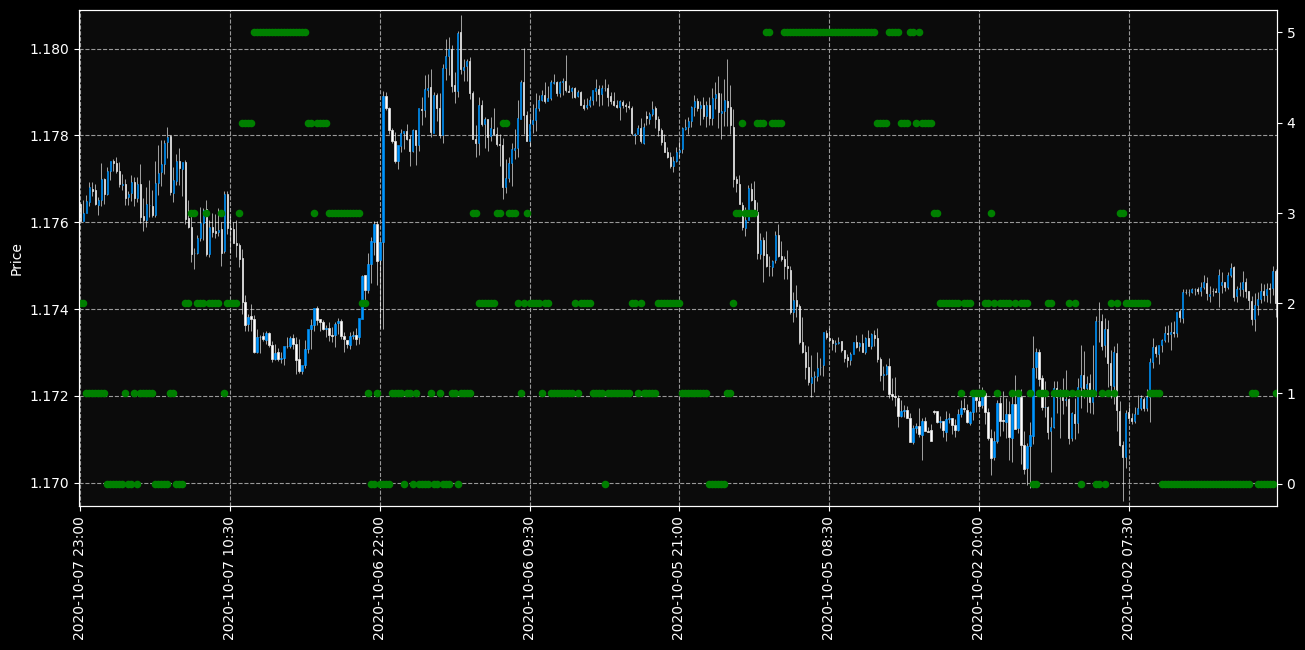

In [47]:


if ('train_images' not in globals() or
    'train_raw' not in globals() or
        'train_labels' not in globals()):
    dict_data = load('train_data.npz')
    train_images = dict_data['images']
    train_raw = dict_data['raw']
    train_labels = dict_data['labels']



df = pd.DataFrame(data={'time': train_raw[0], 'open': train_raw[1], 'high': train_raw[2], 'low': train_raw[3],
                        'close': train_raw[4], 'label0': train_labels[7]+train_labels[8]+train_labels[9]+train_labels[10]+train_labels[11]})
# df = df[::-1].reset_index()


p = df[:400]
p['Time'] = pd.to_datetime(p['time'], unit='s')
p = p.set_index('Time')


# p = df
apds = [
    mpf.make_addplot(p['label0'], type='scatter', markersize=20, color='green', secondary_y=True),
    # mpf.make_addplot(p['label_up'], type='scatter', markersize=10, color='green', secondary_y=True),
    # mpf.make_addplot(p['label_down'], type='scatter', markersize=10, color='orange', secondary_y=True),
    # mpf.make_addplot(p['p_increase'], type='scatter', markersize=20, color='lime', marker='x', secondary_y=True),
    # mpf.make_addplot(p['p_decrease'], type='scatter', markersize=20, color='red', marker='x', secondary_y=True),
    # mpf.make_addplot(p['sell'], type='scatter',markersize=50, marker='v', color='orange'),
    # mpf.make_addplot(p['buy'], type='scatter', markersize=50, marker='^', color='lime'),
    # mpf.make_addplot(p['buy_tp'], type='scatter', markersize=50, marker='x', color='green'),
    # mpf.make_addplot(p['buy_sl'], type='scatter', markersize=50, marker='x', color='red'),
    # mpf.make_addplot(p['sell_tp'], type='scatter', markersize=50, marker='x', color='green'),
    # mpf.make_addplot(p['sell_sl'], type='scatter', markersize=50, marker='x', color='red'),
]

fig, axes = mpf.plot(p, addplot=apds, figratio=(24, 10), type='candle', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=10, axis='x')
plt.show()


In [65]:
print(np.array(train_raw).shape)
print(np.array(train_labels[0]).shape)
print(np.array(train_images).shape)

train_images=np.array(train_images)
train_labels=np.array(train_labels)

(5, 1629)
(1629,)
(1629, 121, 151)


In [ ]:
# features_m5[-8,:100]

# a = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_m15[:109,:IMAGE_LENGTH_M15]], features_m15[109:-1,:IMAGE_LENGTH_M15]))
# b = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_h1[:109,:IMAGE_LENGTH_H1]], features_h1[109:-1,:IMAGE_LENGTH_H1]))
# c = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_h4[:109,:IMAGE_LENGTH_H4]], features_h4[109:-1,:IMAGE_LENGTH_H4]))
# d = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_m5[:109,:IMAGE_LENGTH_M5]], features_m5[109:-1,:IMAGE_LENGTH_M5]))
# e = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_d1[:109,:IMAGE_LENGTH_D1]], features_d1[109:-1,:IMAGE_LENGTH_D1]))
# f = np.hstack((a,b,c,d,e))

plt.figure(figsize=(26, 5))
plt.imshow(outs[:,200:400])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[-i])
    # plt.xlabel(outs[1,i])
plt.show()

In [107]:

MODELS_FOLDER='models_121x151/'

for i in range(14):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(121, IMAGE_WIDTH)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    model.fit(train_images, train_labels[i], epochs=20)
    model.save(MODELS_FOLDER + 'model_' + str(i))



ccuracy: 0.8995
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 0.1222 - accuracy: 0.9555
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 0.2323 - accuracy: 0.9250
Epoch 8/20
63/63 [==============================] - 0s 8ms/step - loss: 0.2694 - accuracy: 0.9055
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 0.0780 - accuracy: 0.9700
Epoch 10/20
63/63 [==============================] - 1s 8ms/step - loss: 0.0644 - accuracy: 0.9780
Epoch 11/20
63/63 [==============================] - 0s 8ms/step - loss: 0.0914 - accuracy: 0.9650
Epoch 12/20
63/63 [==============================] - 0s 8ms/step - loss: 0.1371 - accuracy: 0.9475
Epoch 13/20
63/63 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 0s 8ms/step - loss: 0.0505 - accuracy: 0.9800
Epoch 15/20
63/63 [==============================] - 1s 8ms/step - loss: 0.1424 - accuracy: 0.945

In [ ]:


test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [108]:
# predict 0 -> 7

from numpy import load

models = [tf.keras.models.load_model(MODELS_FOLDER + 'model_0'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_1'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_2'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_3'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_4'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_5'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_6'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_7'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_8'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_9'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_10'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_11'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_12'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_13')]


if ('test_images' not in globals() or
    'test_raw' not in globals() or
        'test_labels' not in globals()):
    dict_data = load('test_data.npz')
    test_images = dict_data['images']
    test_raw = dict_data['raw']
    test_labels = dict_data['labels']

predictions = np.array([np.argmax(models[0].predict(test_images), axis=-1),
                        np.argmax(models[1].predict(test_images), axis=-1),
                        np.argmax(models[2].predict(test_images), axis=-1),
                        np.argmax(models[3].predict(test_images), axis=-1),
                        np.argmax(models[4].predict(test_images), axis=-1),
                        np.argmax(models[5].predict(test_images), axis=-1),
                        np.argmax(models[6].predict(test_images), axis=-1),
                        np.argmax(models[7].predict(test_images), axis=-1),
                        np.argmax(models[8].predict(test_images), axis=-1),
                        np.argmax(models[9].predict(test_images), axis=-1),
                        np.argmax(models[10].predict(test_images), axis=-1),
                        np.argmax(models[11].predict(test_images), axis=-1),
                        np.argmax(models[12].predict(test_images), axis=-1),
                        np.argmax(models[13].predict(test_images), axis=-1)])



from numpy import savez_compressed
savez_compressed('predictions.npz', predictions=predictions)


# R122 Will it drop more than 0.4% Yes no
# R123 Will it drop more than 0.8% Yes no
# R124 Will it drop more than 1.2% Yes no
# R125 Will it drop more than 1.6% Yes no
# R126 Will it drop more than 2.0% Yes no
# R127 Will it drop more than 2.4% Yes no
# R128 Will it drop more than 2.8% Yes no
# R129 Will it increase more than 0.4% Yes no
# R130 Will it increase more than 0.8% Yes no
# R131 Will it increase more than 1.2% Yes no
# R132 Will it increase more than 1.6% Yes no
# R133 Will it increase more than 2.0% Yes no
# R134 Will it increase more than 2.4% Yes no
# R135 Will it increase more than 2.8% Yes no



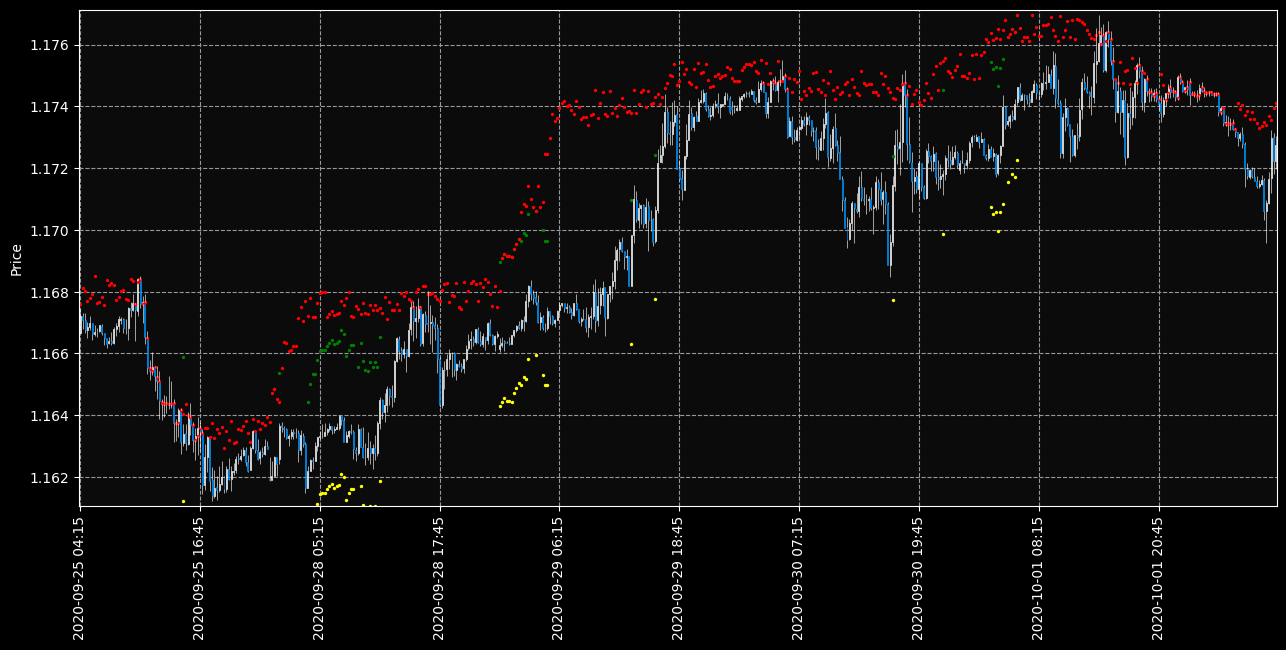

In [288]:


# load dict of arrays
if 'predictions' not in globals():
    dict_data = load('predictions.npz')
    predictions = dict_data['predictions']

if ('test_images' not in globals() or
    'test_raw' not in globals() or
        'test_labels' not in globals()):
    dict_data = load('test_data.npz')
    test_images = dict_data['images']
    test_raw = dict_data['raw']
    test_labels = dict_data['labels']


def _return(d: pd.Series):
    return d.iloc[-1]/d.iloc[0]-1



pred_buy = predictions[7]+predictions[8]+predictions[9]+predictions[10]+predictions[11]+predictions[12]+predictions[13]
pred_sell = (predictions[0]+predictions[1]+predictions[2]+predictions[3]+predictions[4]+predictions[5]+predictions[6])

lb_p_buy = test_labels[7]+test_labels[8]+test_labels[9]+test_labels[10]+test_labels[11]+test_labels[12]+test_labels[13]
lb_p_sell = (test_labels[0]+test_labels[1]+test_labels[2]+test_labels[3]+test_labels[4]+test_labels[5]+test_labels[6])

p_buy = pred_buy.astype(float)
p_sell = pred_sell.astype(float)

THRESOLD_DIFF = 4
TARGET = 3

buy = (TARGET * LABEL_BASE_RATE + 1) * test_raw[1]
sell = (-2 * LABEL_BASE_RATE + 1) * test_raw[1]

lb_buy = (lb_p_buy * LABEL_BASE_RATE + 1) * test_raw[1]
lb_sell = (-lb_p_sell * LABEL_BASE_RATE + 1) * test_raw[1]

diff_buy = pred_buy - lb_p_buy
diff_buy[diff_buy < 0] = 0
diff_sell = pred_sell - lb_p_sell

buy_condition = (pred_buy > pred_sell + THRESOLD_DIFF) & (pred_buy >= TARGET)

# Buy:
# p_buy > p_sell + THRESOLD_DIFF
# p_buy >= TARGET
# tp: TARGET   | sl: TARGET_SL

buy[buy_condition == 0] = np.nan
sell[buy_condition == 0] = np.nan



df = pd.DataFrame(data={'time': test_raw[0], 'open': test_raw[1], 'high': test_raw[2], 'low': test_raw[3],
                        'close': test_raw[4], 'sell': sell, 'buy': buy, 'p_sell': -p_sell, 'p_buy': p_buy, 'lb_buy':lb_buy,
                        'lb_sell':lb_sell, 'diff_buy':diff_buy,'diff_sell':diff_sell,'lb_p_buy':lb_p_buy,'pred_buy':pred_buy })
df = df[::-1].reset_index()


# df['pred_buy_ma'] = df['pred_buy'].rolling(48).mean()
# df['lb_p_buy_ma'] = df['lb_p_buy'].rolling(48).mean()
# df['diff_buy_ma'] = df['diff_buy'].rolling(48).mean()


p = df[500:1000]
p['Time'] = pd.to_datetime(p['time'], unit='s')
p = p.set_index('Time')


# p = df
apds = [
    mpf.make_addplot(p['buy'], type='scatter', markersize=2, color='green', secondary_y=False),
    mpf.make_addplot(p['sell'], type='scatter', markersize=2, color='yellow', secondary_y=False),
    # mpf.make_addplot(p['lb_buy'], type='scatter', markersize=2, color='red', secondary_y=False),
    # mpf.make_addplot(p['lb_sell'], type='scatter', markersize=2, color='red', secondary_y=False),
    # mpf.make_addplot(p['diff_buy'], type='scatter', markersize=2, color='purple', secondary_y=True),
    # mpf.make_addplot(p['diff_buy_ma'], type='scatter', markersize=2, color='lime', secondary_y=True),
    # mpf.make_addplot(p['p_buy'], type='scatter', markersize=2, color='orange', secondary_y=True),
    # mpf.make_addplot(p['p_sell'], type='scatter', markersize=2, color='green', secondary_y=True),
    # mpf.make_addplot(p['pred_buy_ma'], type='scatter', markersize=2, color='yellow', secondary_y=True),
    # mpf.make_addplot(p['lb_p_buy'], type='scatter', markersize=6, color='red', secondary_y=True),
    # mpf.make_addplot(p['p_sell'], type='scatter', markersize=6, color='red', secondary_y=True),
]

fig, axes = mpf.plot(p, addplot=apds, figratio=(24, 10), type='candle', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=10, axis='x')
axes[1].set_ylim((-8,8))
plt.show()


In [ ]:
%reset

In [290]:
diff_buy = pred_buy - lb_p_buy
# diff_buy[diff_buy < 0] = 0
# plt.hist(diff_buy, facecolor='red', alpha=0.5)
# TARGET = 2
TRADE_SIZE = 0.02
TRADE_PROFIT = TRADE_SIZE * 100000 * LABEL_BASE_RATE
FEE = TRADE_SIZE * 7

# for TARGET in range(1,5):
#     for TARGET_SL in range(1,5):
#         for i in range(6):
#             buy_condition = (pred_buy > pred_sell + i) & (pred_buy >= TARGET)
#             buy_pos = (lb_p_buy >= TARGET) & (lb_p_sell < TARGET_SL) & buy_condition
#             buy_neg = ((lb_p_buy < TARGET) | (lb_p_sell >= TARGET_SL)) & buy_condition
#             x = buy_pos.sum()
#             y = buy_neg.sum()
#             print(TARGET, TARGET_SL, i, ':', x, y, x-y, x * TARGET * TRADE_PROFIT - y * TARGET_SL * TRADE_PROFIT - (x + y) * FEE)


for TARGET in range(1,5):
    for TARGET_SL in range(1,5):
        for i in range(6):
            sell_condition = (pred_sell > pred_buy + i) & (pred_sell >= TARGET)
            sell_pos = (lb_p_sell >= TARGET) & (lb_p_buy < TARGET_SL) & sell_condition
            sell_neg = ((lb_p_sell < TARGET) | (lb_p_buy >= TARGET_SL)) & sell_condition
            x = sell_pos.sum()
            y = sell_neg.sum()
            print(TARGET, TARGET_SL, i, ':', x, y, x-y, x * TARGET * TRADE_PROFIT - y * TARGET_SL * TRADE_PROFIT - (x + y) * FEE)


# 1 0 : 666 141 525 33.14
# 1 1 : 528 83 445 101.14
# 1 2 : 381 38 343 129.94000000000005
# 1 3 : 251 19 232 101.34000000000005
# 1 4 : 93 9 84 32.540000000000006
# 1 5 : 5 0 5 3.14
# 2 0 : 507 292 215 -110.86
# 2 1 : 414 197 217 83.54000000000009
# 2 2 : 312 107 205 237.14
# 2 3 : 208 62 146 197.34000000000003
# 2 4 : 87 15 72 128.54
# 2 5 : 5 0 5 11.14
# 3 0 : 318 357 -39 -862.0600000000001
# 3 1 : 279 281 -2 -569.46
# 3 2 : 216 203 13 -356.46000000000004
# 3 3 : 152 118 34 -106.65999999999998
# 3 4 : 82 20 62 195.74
# 3 5 : 5 0 5 19.14


# for TARGET in range(1,4):
#     for TARGET_SL in range(1,5):
#         for i in range(6):
#             buy_condition = (pred_buy > pred_sell + i) & (pred_buy >= TARGET)
#             buy_pos = (diff_buy <= 0) & (lb_p_sell < TARGET_SL) & buy_condition
#             buy_neg = ((diff_buy > 0) | (lb_p_sell >= TARGET_SL)) & buy_condition
#             x = buy_pos.sum()
#             y = buy_neg.sum()
#             pos = pred_buy[buy_pos].sum()
#             neg = pred_buy[buy_neg].sum()
#             print(TARGET, i, ':', pos, neg,x,y, pos * TRADE_PROFIT - y * TARGET_SL * TRADE_PROFIT - (x + y)*FEE)

# 1 0 : 829 2267 228 579 -406.86
# 1 1 : 653 1849 163 448 -282.86
# 1 2 : 444 1415 100 319 -218.86
# 1 3 : 300 959 65 205 -117.86
# 1 4 : 151 380 30 72 24.540000000000006
# 1 5 : 6 28 1 4 -1.6599999999999997
# 2 0 : 823 2265 222 577 -11.659999999999954
# 2 1 : 653 1849 163 448 45.14
# 2 2 : 444 1415 100 319 -18.86
# 2 3 : 300 959 65 205 34.14
# 2 4 : 151 380 30 72 150.94
# 2 5 : 6 28 1 4 1.5400000000000005
# 3 0 : 733 2107 177 498 453.14
# 3 1 : 621 1779 147 413 438.5400000000001
# 3 2 : 444 1415 100 319 181.14
# 3 3 : 300 959 65 205 186.14
# 3 4 : 151 380 30 72 277.34000000000003
# 3 5 : 6 28 1 4 4.740000000000001

# plt.hist2d(diff_buy, pred_buy)
# plt.hist2d(lb_p_buy, pred_buy)
# plt.show()

1 1 0 : 272 558 -286 -573.8000000000001
1 1 1 : 196 396 -200 -402.88
1 1 2 : 133 255 -122 -249.51999999999998
1 1 3 : 59 110 -51 -105.25999999999999
1 1 4 : 25 45 -20 -41.8
1 1 5 : 9 16 -7 -14.700000000000001
1 2 0 : 522 308 214 -266.6
1 2 1 : 377 215 162 -167.67999999999995
1 2 2 : 249 139 110 -100.71999999999998
1 2 3 : 106 63 43 -55.660000000000004
1 2 4 : 45 25 20 -17.8
1 2 5 : 16 9 7 -6.699999999999999
1 3 0 : 619 211 408 -138.6
1 3 1 : 444 148 296 -82.88000000000001
1 3 2 : 294 94 200 -35.12000000000002
1 3 3 : 123 46 77 -47.660000000000004
1 3 4 : 50 20 30 -25.8
1 3 5 : 17 8 9 -14.700000000000003
1 4 0 : 650 180 470 -228.20000000000002
1 4 1 : 460 132 328 -191.68000000000006
1 4 2 : 304 84 220 -105.52
1 4 3 : 124 45 79 -113.25999999999999
1 4 4 : 51 19 32 -49.8
1 4 5 : 18 7 11 -19.500000000000004
2 1 0 : 220 596 -376 -363.84000000000003
2 1 1 : 158 434 -276 -271.68000000000006
2 1 2 : 99 289 -190 -199.92000000000002
2 1 3 : 46 123 -77 -73.25999999999999
2 1 4 : 24 46 -22 -6.5999